# Unit09_Process_Safety_Anomaly_Detection | 製程安全與異常偵測

本 Notebook 使用合成數據與 PCA/MSPC 方法建立製程異常偵測模型，示範 Isolation Forest 與多變數統計製程控制技術。

## 目標
- 使用 Isolation Forest 偵測單變數壓力訊號異常（Spike/振盪/Drift）
- 建立 PCA/MSPC 模型進行多變數異常偵測（T²/SPE統計量）
- 設計實用告警邏輯（分級告警、連續超標、EWMA/CUSUM）
- 實作 OOD Gate 機制確保模型輸入品質

對應講義：`Part_2/Unit09_Process_Safety_Anomaly_Detection.md`

---
## 0. 環境設定

In [1]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit09_Process_Safety_Anomaly_Detection'
SOURCE_DATA_DIR = 'process_safety'  # 本範例使用合成數據，不需要實際資料夾

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit09'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

print("\n註：本範例使用合成數據，無需外部數據源")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\data\process_safety
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Process_Safety_Anomaly_Detection
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Process_Safety_Anomaly_Detection\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Process_Safety_Anomaly_Detection\figs

註：本範例使用合成數據，無需外部數據源


In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# sklearn套件
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(SEED)
RNG = np.random.default_rng(SEED)

# 設定繪圖風格
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.unicode_minus'] = False

print('✓ 套件載入完成')
print(f'NumPy 版本: {np.__version__}')
print(f'Pandas 版本: {pd.__version__}')
print(f'Scikit-learn 已載入 (IsolationForest, PCA, StandardScaler)')

✓ 套件載入完成
NumPy 版本: 1.23.5
Pandas 版本: 2.3.3
Scikit-learn 已載入 (IsolationForest, PCA, StandardScaler)


## 1) 單變數：壓力訊號異常

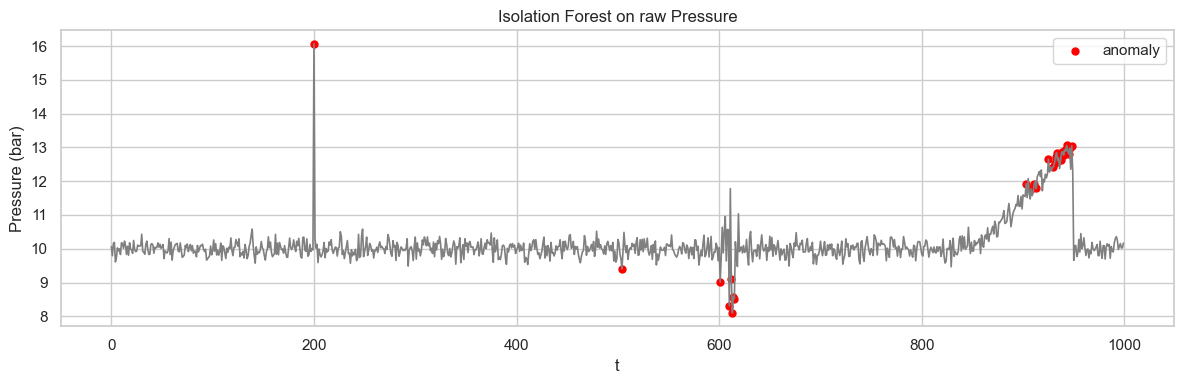

✓ 已儲存: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Process_Safety_Anomaly_Detection\figs\01_pressure_iforest_raw.png


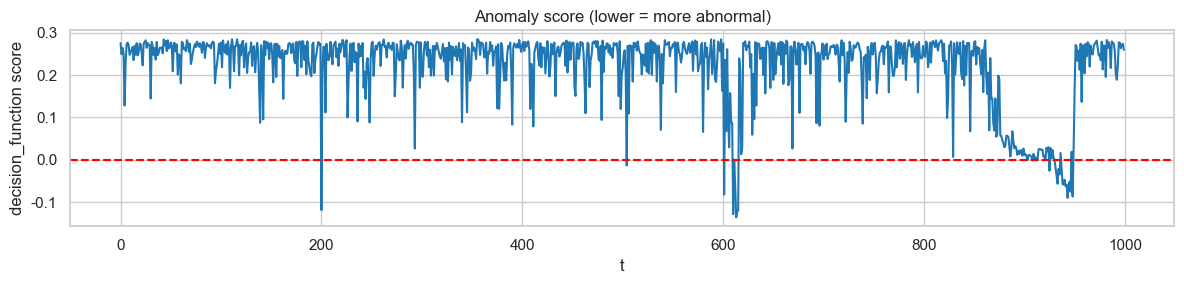

✓ 已儲存: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Process_Safety_Anomaly_Detection\figs\02_score_raw.png


In [3]:
n = 1000
time = np.arange(n)

pressure = 10.0 + RNG.normal(0, 0.2, size=n)
pressure[200] += 6.0  # spike
pressure[600:620] += RNG.normal(0, 1.2, size=20)  # fluctuation
pressure[850:950] += np.linspace(0, 3.0, 100)  # drift

df_p = pd.DataFrame({'t': time, 'Pressure': pressure})
X = df_p[['Pressure']].values

iso = IsolationForest(contamination=0.03, random_state=42)
iso.fit(X)
df_p['score'] = iso.decision_function(X)
df_p['label'] = iso.predict(X)  # -1 anomaly

plt.figure(figsize=(12, 4))
plt.plot(df_p['t'], df_p['Pressure'], color='gray', linewidth=1.2)
plt.scatter(df_p.loc[df_p['label']==-1, 't'], df_p.loc[df_p['label']==-1, 'Pressure'],
            color='red', s=25, label='anomaly')
plt.xlabel('t')
plt.ylabel('Pressure (bar)')
plt.title('Isolation Forest on raw Pressure')
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / '01_pressure_iforest_raw.png', dpi=150)
plt.show()
print(f'✓ 已儲存: {FIG_DIR / "01_pressure_iforest_raw.png"}')

plt.figure(figsize=(12, 3))
plt.plot(df_p['t'], df_p['score'], color='tab:blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('t')
plt.ylabel('decision_function score')
plt.title('Anomaly score (lower = more abnormal)')
plt.tight_layout()
plt.savefig(FIG_DIR / '02_score_raw.png', dpi=150)
plt.show()
print(f'✓ 已儲存: {FIG_DIR / "02_score_raw.png"}')

### 1.1 特徵工程：rolling mean/std

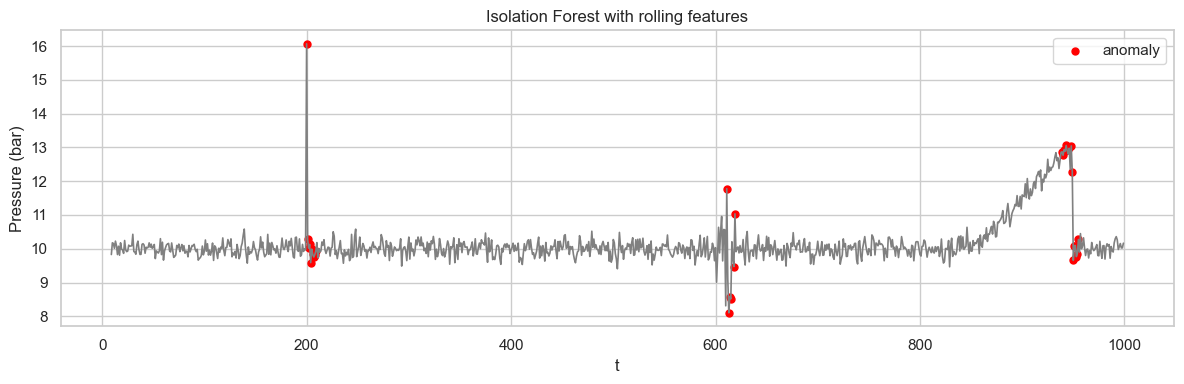

✓ 已儲存: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Process_Safety_Anomaly_Detection\figs\03_pressure_iforest_rolling.png


In [4]:
w = 10
df_p['roll_mean'] = df_p['Pressure'].rolling(w).mean()
df_p['roll_std'] = df_p['Pressure'].rolling(w).std()
df_p2 = df_p.dropna().copy()

X2 = df_p2[['Pressure','roll_mean','roll_std']].values
iso2 = IsolationForest(contamination=0.03, random_state=42)
iso2.fit(X2)
df_p2['score2'] = iso2.decision_function(X2)
df_p2['label2'] = iso2.predict(X2)

plt.figure(figsize=(12, 4))
plt.plot(df_p2['t'], df_p2['Pressure'], color='gray', linewidth=1.2)
plt.scatter(df_p2.loc[df_p2['label2']==-1, 't'], df_p2.loc[df_p2['label2']==-1, 'Pressure'],
            color='red', s=25, label='anomaly')
plt.xlabel('t')
plt.ylabel('Pressure (bar)')
plt.title('Isolation Forest with rolling features')
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / '03_pressure_iforest_rolling.png', dpi=150)
plt.show()
print(f'✓ 已儲存: {FIG_DIR / "03_pressure_iforest_rolling.png"}')

## 2) 多變數：PCA/MSPC（T^2 / SPE）

In [5]:
n = 2400
t = np.arange(n)

p = 10
mu = np.zeros(p)
A = RNG.normal(size=(p, p))
cov = (A @ A.T)
cov = cov / np.max(np.diag(cov))

X = RNG.multivariate_normal(mu, cov, size=n)

fault_start = 1600
X[fault_start:, 0] += np.linspace(0, 3.0, n - fault_start)  # drift on var0
X[fault_start:, 3] += RNG.normal(0, 1.0, size=n - fault_start)  # correlation break

cols = [f'Var{i:02d}' for i in range(p)]
df_m = pd.DataFrame(X, columns=cols)
df_m['t'] = t

baseline_idx = df_m['t'] < fault_start
sc = StandardScaler()
X_base = sc.fit_transform(df_m.loc[baseline_idx, cols])
X_all = sc.transform(df_m[cols])

pca = PCA(n_components=5, random_state=42)
T_base = pca.fit_transform(X_base)
T_all = pca.transform(X_all)

evals = pca.explained_variance_
T2 = np.sum((T_all ** 2) / evals, axis=1)

X_hat = pca.inverse_transform(T_all)
resid = X_all - X_hat
SPE = np.sum(resid ** 2, axis=1)

T2_thr = float(np.quantile(T2[baseline_idx.values], 0.99))
SPE_thr = float(np.quantile(SPE[baseline_idx.values], 0.99))

print('T2_thr (99%):', round(T2_thr, 3))
print('SPE_thr (99%):', round(SPE_thr, 3))


T2_thr (99%): 14.371
SPE_thr (99%): 3.455


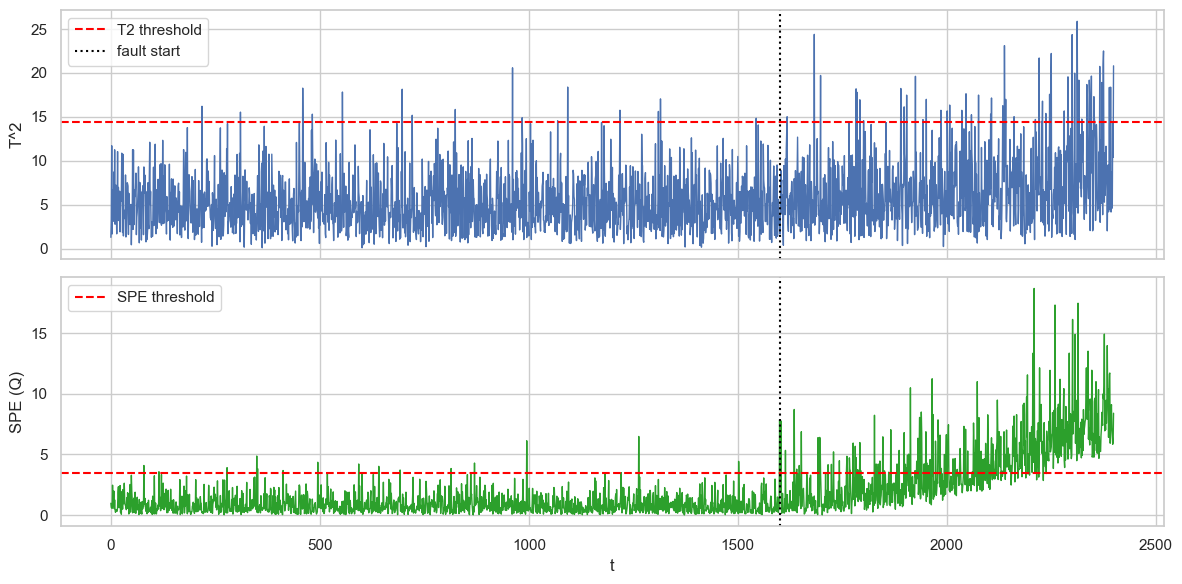

✓ 已儲存: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Process_Safety_Anomaly_Detection\figs\04_mspc_t2_spe.png


In [6]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

ax[0].plot(df_m['t'], T2, linewidth=1.0)
ax[0].axhline(T2_thr, color='red', linestyle='--', label='T2 threshold')
ax[0].axvline(fault_start, color='black', linestyle=':', label='fault start')
ax[0].set_ylabel('T^2')
ax[0].legend()

ax[1].plot(df_m['t'], SPE, linewidth=1.0, color='tab:green')
ax[1].axhline(SPE_thr, color='red', linestyle='--', label='SPE threshold')
ax[1].axvline(fault_start, color='black', linestyle=':')
ax[1].set_xlabel('t')
ax[1].set_ylabel('SPE (Q)')
ax[1].legend()

plt.tight_layout()
plt.savefig(FIG_DIR / '04_mspc_t2_spe.png', dpi=150)
plt.show()
print(f'✓ 已儲存: {FIG_DIR / "04_mspc_t2_spe.png"}')

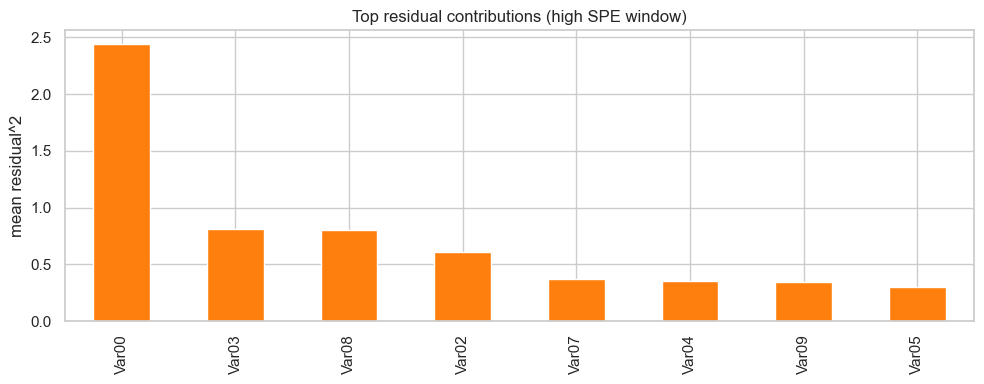

✓ 已儲存: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Process_Safety_Anomaly_Detection\figs\05_spe_contribution.png


Var00    2.439514
Var03    0.811033
Var08    0.798375
Var02    0.606693
Var07    0.370727
Var04    0.351911
Var09    0.340114
Var05    0.298810
Var01    0.206968
Var06    0.117173
dtype: float64

In [7]:
high_idx = (df_m['t'] >= fault_start) & (SPE > SPE_thr)
contrib = (resid[high_idx.values] ** 2).mean(axis=0)
contrib_s = pd.Series(contrib, index=cols).sort_values(ascending=False)

plt.figure(figsize=(10, 4))
contrib_s.head(8).plot(kind='bar', color='tab:orange')
plt.title('Top residual contributions (high SPE window)')
plt.ylabel('mean residual^2')
plt.tight_layout()
plt.savefig(FIG_DIR / '05_spe_contribution.png', dpi=150)
plt.show()
print(f'✓ 已儲存: {FIG_DIR / "05_spe_contribution.png"}')

display(contrib_s.head(12))

## 3) 告警設計：分級、連續超標、EWMA/CUSUM（更像工廠值班）

這段把模型輸出變成可用的警報：
- **單點超標** 很容易誤報
- **連續 N 點超標** 更像工廠 alarm 設計
- **EWMA/CUSUM** 用於抓慢性漂移（比單點敏感）


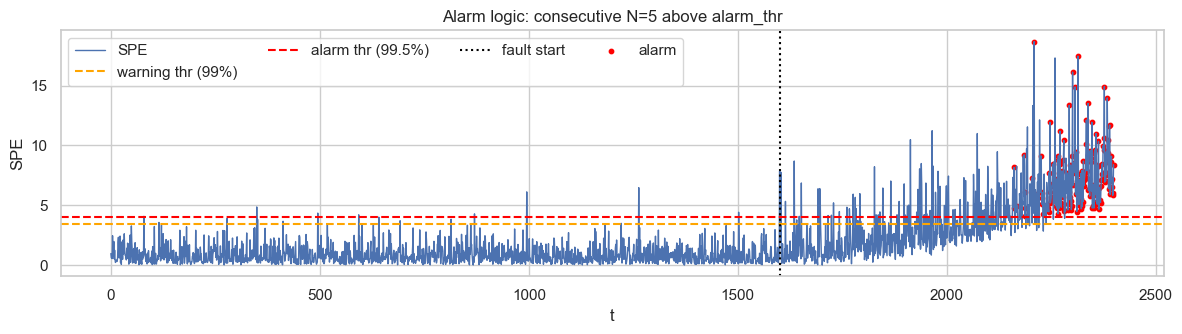

✓ 已儲存: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Process_Safety_Anomaly_Detection\figs\07_alarm_logic_spe.png
Counts: {0: 2000, 1: 237, 2: 163}


In [8]:
# 3.1 對 MSPC 指標做分級告警（示範）：warning / alarm

# 以 SPE 為例（你也可對 T2 做同樣規則）

spe = SPE.copy()

warning_thr = SPE_thr
alarm_thr = float(np.quantile(SPE[baseline_idx.values], 0.995))

# 連續超標 N 點才算 alarm
N_consec = 5

state = np.zeros_like(spe, dtype=int)  # 0 normal, 1 warning, 2 alarm

consec = 0
for i in range(len(spe)):
    if spe[i] > alarm_thr:
        consec += 1
        if consec >= N_consec:
            state[i] = 2
        else:
            state[i] = 1
    elif spe[i] > warning_thr:
        consec = 0
        state[i] = 1
    else:
        consec = 0
        state[i] = 0

plt.figure(figsize=(12, 3.5))
plt.plot(df_m['t'], spe, linewidth=1.0, label='SPE')
plt.axhline(warning_thr, color='orange', linestyle='--', label='warning thr (99%)')
plt.axhline(alarm_thr, color='red', linestyle='--', label='alarm thr (99.5%)')
plt.axvline(fault_start, color='black', linestyle=':', label='fault start')

# 標示 alarm 點
alarm_idx = np.where(state == 2)[0]
plt.scatter(df_m['t'].iloc[alarm_idx], spe[alarm_idx], color='red', s=10, label='alarm')

plt.xlabel('t')
plt.ylabel('SPE')
plt.title(f'Alarm logic: consecutive N={N_consec} above alarm_thr')
plt.legend(ncol=4)
plt.tight_layout()
plt.savefig(FIG_DIR / '07_alarm_logic_spe.png', dpi=150)
plt.show()
print(f'✓ 已儲存: {FIG_DIR / "07_alarm_logic_spe.png"}')

print('Counts:', dict(zip(*np.unique(state, return_counts=True))))

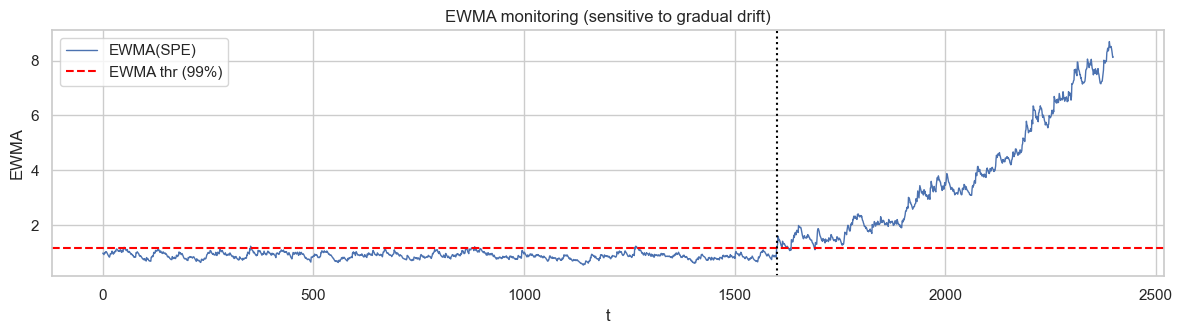

✓ 已儲存: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Process_Safety_Anomaly_Detection\figs\08_ewma_spe.png


In [9]:
# 3.2 EWMA：抓慢性漂移（示範用 SPE 或單一關鍵 tag）

# 這裡用 SPE 做 EWMA 示範
alpha = 0.05
z = np.zeros_like(spe)
z[0] = spe[0]
for i in range(1, len(spe)):
    z[i] = alpha * spe[i] + (1 - alpha) * z[i-1]

# 用基準期 EWMA 的 99% 當門檻
z_thr = float(np.quantile(z[baseline_idx.values], 0.99))

plt.figure(figsize=(12, 3.5))
plt.plot(df_m['t'], z, linewidth=1.0, label='EWMA(SPE)')
plt.axhline(z_thr, color='red', linestyle='--', label='EWMA thr (99%)')
plt.axvline(fault_start, color='black', linestyle=':')
plt.xlabel('t')
plt.ylabel('EWMA')
plt.title('EWMA monitoring (sensitive to gradual drift)')
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / '08_ewma_spe.png', dpi=150)
plt.show()
print(f'✓ 已儲存: {FIG_DIR / "08_ewma_spe.png"}')

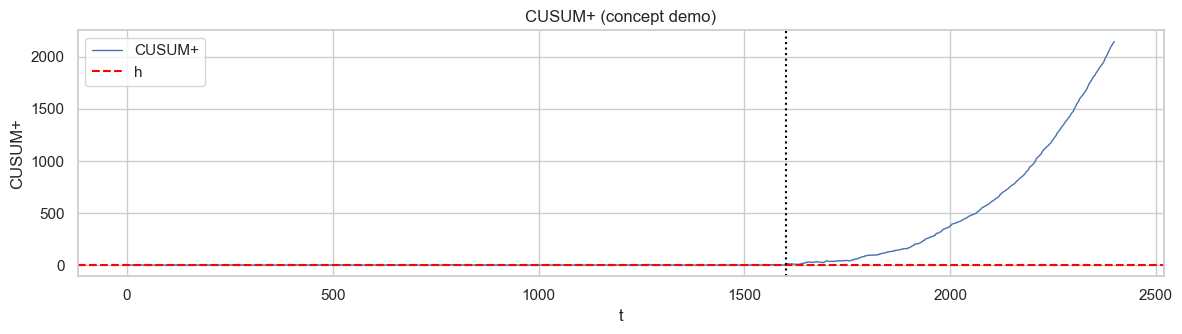

✓ 已儲存: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Process_Safety_Anomaly_Detection\figs\09_cusum_spe.png


In [10]:
# 3.3 CUSUM（概念示範）：累積偏移，對小偏移更敏感

# CUSUM for SPE relative to baseline mean
mu0 = float(np.mean(spe[baseline_idx.values]))

k = float(np.std(spe[baseline_idx.values]) * 0.5)  # reference value
h = float(np.std(spe[baseline_idx.values]) * 5.0)  # decision interval

c_pos = np.zeros_like(spe)
for i in range(1, len(spe)):
    c_pos[i] = max(0.0, c_pos[i-1] + (spe[i] - mu0 - k))

plt.figure(figsize=(12, 3.5))
plt.plot(df_m['t'], c_pos, linewidth=1.0, label='CUSUM+')
plt.axhline(h, color='red', linestyle='--', label='h')
plt.axvline(fault_start, color='black', linestyle=':')
plt.xlabel('t')
plt.ylabel('CUSUM+')
plt.title('CUSUM+ (concept demo)')
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / '09_cusum_spe.png', dpi=150)
plt.show()
print(f'✓ 已儲存: {FIG_DIR / "09_cusum_spe.png"}')

## 4) OOD Gate（上線必備）：輸入超界就降級，不要硬輸出

最小可用做法：
- 以基準期的 z-score 範圍建立 gate
- 若某些關鍵 tag 超界太多，直接標記資料品質問題或進入「保守模式」


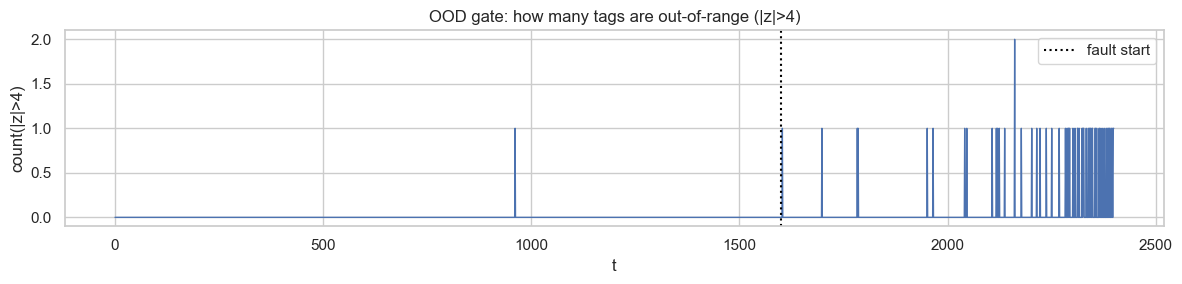

✓ 已儲存: d:\MyGit\CHE-AI-COURSE\Part_2\Unit09\outputs\P2_Unit09_Process_Safety_Anomaly_Detection\figs\10_ood_gate_zcount.png

=== OOD Gate 統計分析 ===
門檻 > 0: 總標記率=0.025, 故障期標記率=0.072
門檻 > 1: 總標記率=0.000, 故障期標記率=0.001
門檻 > 2: 總標記率=0.000, 故障期標記率=0.000

✓ 採用門檻 > 0，總標記率: 0.025
  基準期標記率: 0.001
  故障期標記率: 0.072


In [12]:
# 4.1 用 baseline 的 z-score 建立最小 gate

# 以 StandardScaler 後的輸入 X_all（多變數）為例
Z_in = X_all  # already standardized by baseline scaler

# 以 |z| > 4 當超界（示範；實務可用每個 tag 的工程上限）
out_of_range = (np.abs(Z_in) > 4.0).sum(axis=1)

plt.figure(figsize=(12, 3))
plt.plot(df_m['t'], out_of_range, linewidth=1.0)
plt.axvline(fault_start, color='black', linestyle=':', label='fault start')
plt.xlabel('t')
plt.ylabel('count(|z|>4)')
plt.title('OOD gate: how many tags are out-of-range (|z|>4)')
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / '10_ood_gate_zcount.png', dpi=150)
plt.show()
print(f'✓ 已儲存: {FIG_DIR / "10_ood_gate_zcount.png"}')

# gate decision：測試不同門檻的效果
print('\n=== OOD Gate 統計分析 ===')
for thr in [0, 1, 2]:
    gate_flag = out_of_range > thr
    flagged_ratio = float(np.mean(gate_flag))
    flagged_in_fault = float(np.mean(gate_flag[fault_start:]))
    print(f'門檻 > {thr}: 總標記率={flagged_ratio:.3f}, 故障期標記率={flagged_in_fault:.3f}')

# 建議使用門檻 > 0（任何變數超界就警示）
gate_flag = out_of_range > 0
print(f'\n✓ 採用門檻 > 0，總標記率: {float(np.mean(gate_flag)):.3f}')
print(f'  基準期標記率: {float(np.mean(gate_flag[:fault_start])):.3f}')
print(f'  故障期標記率: {float(np.mean(gate_flag[fault_start:])):.3f}')

---
## 5) 總結與實務建議

### 5.1 本範例學到的技術

1. **Isolation Forest**：適用於單變數或低維度異常偵測
   - 優點：無需假設資料分布、訓練快速
   - 限制：對緩慢漂移不敏感（需加入 rolling features）

2. **PCA/MSPC**：製程工業標準做法
   - **T² 統計量**：偵測主空間異常（變數間相關性變化）
   - **SPE (Q)** 統計量：偵測殘差空間異常（新模式）
   - **貢獻度分析**：診斷哪些變數導致異常

3. **實務告警設計**：避免誤報是關鍵
   - 分級告警（warning/alarm）：給操作員反應時間
   - 連續超標邏輯：減少雜訊干擾
   - EWMA/CUSUM：對漂移敏感

4. **OOD Gate**：確保模型輸入品質
   - 基於 z-score 的簡單檢查
   - 超界時應降級或改用保守策略

### 5.2 實際應用注意事項

⚠️ **資料品質**：
- 基準期必須是「正常運行」，不能包含異常數據
- 需定期更新基準（製程條件改變時）

⚠️ **閾值設定**：
- 99% 是起點，需根據誤報率調整
- 工廠值班可能需要 99.5% 或 99.9% 減少誤報

⚠️ **多模態製程**：
- 不同操作模式需要分別建立模型
- 或使用動態 PCA / Moving Window PCA

⚠️ **計算效率**：
- 線上監控需要快速計算（毫秒級）
- PCA 轉換非常快，適合即時應用

### 5.3 延伸學習

- **動態 PCA**：處理時序相關性（加入 lag variables）
- **FDA (Fisher Discriminant Analysis)**：有標記異常數據時更有效
- **Deep Autoencoder**：非線性降維，捕捉複雜模式
- **TEP (Tennessee Eastman Process)**：工業標準測試資料集